In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [0]:
plt.rcParams["figure.figsize"] = (6,6)

In [0]:
import numpy as np
import pandas as pd

In [0]:
import json

In [0]:
import tqdm
import pathlib

In [0]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [0]:
RS = 2734
DATA_DIR = pathlib.Path("./")

In [0]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

### Версии:

- `numpy`: 1.16.5
- `pandas`: 0.24.2
- `sklearn`: 0.21.3
- `tensorflow`: 2.0.0

# Загрузка данных

In [0]:
train_data = pd.read_csv(DATA_DIR.joinpath("activity_train.csv.zip"),
                         parse_dates=["date"], index_col="date",
                         compression="zip")
test_data = pd.read_csv(DATA_DIR.joinpath("activity_test.csv.zip"),
                        parse_dates=["date"], index_col="date",
                        compression="zip")
activity_test_target = pd.read_csv(DATA_DIR.joinpath("activity_test_timestamps.csv"),
                                   index_col="date",
                                   parse_dates=["date"])
atactic_test_target = pd.read_csv(DATA_DIR.joinpath("atactic_test_timestamps.csv"),
                                  index_col="date",
                                  parse_dates=["date"])

In [11]:
train_data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,activity,atactic_1,atactic_2,atactic_3
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-02-13 08:30:00,49.048771,294.933268,1.675466,0.000051,0.024688,0.001628,1.724180e+06,728860.217994,1.179884,0.513442,1.681574,0.00005,0.024943,0.001629,758645.068644,1.187274,0.558392,343.170546,343.145621,343.111044,1.574781,1.615477,0.009761,0.009680,301.92330,0.484171,0.557710,0.233514,NaN,195.594428,145.390155,123.790156,66.654695,72.028561,68.728236,64130.855,151915.824330,144110.179996,343.25970,343.34222,343.29892,343.35226,255.800000,101038.077700,77.000000,343.13560,335.67578,335.74625,336.91620,336.97977,342.95605,332.80826,332.81665,5493.318081,4829.339027,521.341026,33.998170,NaN,NaN,NaN
2018-02-13 08:31:00,49.007980,294.932866,1.675090,0.000051,0.024659,0.001633,1.724523e+06,729611.819621,1.179814,0.513436,1.681415,0.00005,0.024994,0.001625,761764.591826,1.187331,0.558663,343.152747,343.151724,343.113585,1.573941,1.612820,0.009769,0.009681,301.90616,0.484099,0.557320,0.233740,NaN,195.485726,145.428082,123.800293,66.707826,71.945526,68.780815,64179.140,151867.461239,144171.923340,343.25750,343.33810,343.31232,343.34326,255.799444,101038.299903,76.988889,343.13806,335.66540,335.73734,336.98390,337.02980,342.97174,332.82263,332.78198,5247.641087,5020.168781,520.791888,34.623659,NaN,NaN,NaN
2018-02-13 08:32:00,48.994400,294.932703,1.675766,0.000051,0.024727,0.001639,1.724582e+06,730361.831348,1.179867,0.513290,1.681492,0.00005,0.024928,0.001629,759461.107963,1.187246,0.558563,343.154272,343.159865,343.116637,1.573461,1.614684,0.009792,0.009695,301.92993,0.483961,0.557615,0.233675,NaN,195.580825,145.386293,124.295153,66.758421,71.957288,68.759196,64251.504,152158.972552,144231.221704,343.25485,343.34143,343.32700,343.34220,255.798889,101038.522107,76.977778,343.13250,335.63095,335.70050,336.97913,337.05157,342.97382,332.84164,332.82962,5000.878811,5207.399845,520.242810,33.969483,NaN,NaN,NaN
2018-02-13 08:33:00,48.970760,294.936968,1.675868,0.000051,0.024723,0.001641,1.724677e+06,730486.077321,1.186719,0.511677,1.681643,0.00005,0.024922,0.001629,760412.241982,1.187280,0.558469,343.150198,343.168005,343.117651,1.573785,1.613456,0.009796,0.009700,301.90567,0.483804,0.557747,0.234117,NaN,195.336998,145.523593,124.203746,66.790413,72.011254,68.779693,64292.312,152426.298143,144232.437181,343.26205,343.34540,343.32513,343.35037,255.798333,101038.744310,76.966667,343.15228,335.57654,335.65533,337.00995,337.05280,342.97943,332.88272,332.88680,4751.941204,5387.604237,521.320522,32.701220,NaN,NaN,NaN
2018-02-13 08:34:00,48.952991,294.935404,1.675002,0.000051,0.024708,0.001646,1.724621e+06,730061.574144,1.186838,0.511305,1.681514,0.00005,0.025069,0.001633,758510.955941,1.187319,0.558569,343.153258,343.163931,343.122229,1.574133,1.615544,0.009814,0.009702,301.92905,0.483762,0.557368,0.234114,NaN,195.578388,145.655553,123.860564,66.786427,71.998048,68.740583,64244.836,152378.899642,144174.016885,343.26550,343.34335,343.33370,343.34286,255.797778,101038.966513,76.955556,343.13647,335.53976,335.63748,337.05005,337.10764,342.98720,332.91257,332.90576,4513.198853,5566.278934,522.398114,32.337694,NaN,NaN,NaN


In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 463058 entries, 2018-02-13 08:30:00 to 2018-12-31 22:07:00
Data columns (total 60 columns):
f0           317593 non-null float64
f1           317594 non-null float64
f2           317594 non-null float64
f3           317570 non-null float64
f4           317621 non-null float64
f5           317621 non-null float64
f6           317594 non-null float64
f7           317593 non-null float64
f8           317544 non-null float64
f9           317574 non-null float64
f10          317621 non-null float64
f11          317621 non-null float64
f12          317621 non-null float64
f13          317621 non-null float64
f14          317621 non-null float64
f15          317486 non-null float64
f16          317574 non-null float64
f17          317424 non-null float64
f18          317621 non-null float64
f19          316271 non-null float64
f20          317621 non-null float64
f21          317621 non-null float64
f22          317621 non-null float64
f23 

In [13]:
test_data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:30:00,57.132648,294.708041,1.636037,0.000052,0.019928,0.001852,1.716315e+06,743388.392658,2.989328,0.591614,1.646756,0.00005,0.021358,0.001885,728283.785888,2.957360,0.620547,343.157317,343.200049,343.169531,1.566593,1.572974,0.008808,0.008749,256.95697,0.587673,0.599083,0.250953,0.00005,194.260592,141.100844,124.783203,67.947631,71.739198,71.534295,70790.300,151334.741368,150731.649942,343.28845,343.31616,343.34677,343.32816,256.883333,101560.255533,86.333333,343.19556,336.59200,336.64236,336.08533,336.16528,343.03546,333.43230,333.38052,522.152305,2178.483009,7568.408012
2019-01-01 00:31:00,57.119122,294.702589,1.635624,0.000052,0.019988,0.001874,1.715817e+06,741369.594337,2.989310,0.591480,1.646189,0.00005,0.021372,0.001898,728682.523340,2.957156,0.620651,343.157317,343.169531,343.157317,1.548230,1.575003,0.008879,0.008834,256.96942,0.587818,0.603940,0.250834,0.00005,194.206377,141.293727,125.035133,67.947564,71.710618,71.548507,70719.375,151149.351955,150849.598695,343.27026,343.32858,343.34863,343.34296,256.872222,101560.403669,86.322222,343.18030,336.59048,336.64197,336.09860,336.19940,343.03375,333.41724,333.36392,522.445917,1944.569945,7747.926235
2019-01-01 00:32:00,57.079891,294.718029,1.634823,0.000052,0.019912,0.001874,1.716210e+06,743306.512832,2.989467,0.591614,1.646378,0.00005,0.021417,0.001899,728362.953532,2.957269,0.620666,343.163428,343.151221,343.157317,1.563145,1.568961,0.008876,0.008837,256.96964,0.587740,0.609142,0.251204,0.00005,194.342554,141.238930,124.848746,67.943305,71.634911,71.518880,70651.650,151055.191389,150957.477354,343.23996,343.33185,343.34772,343.34174,256.861111,101560.551804,86.311111,343.17627,336.60050,336.64154,336.26498,336.40747,343.01495,333.37753,333.29938,523.043394,1710.854053,7923.093796
2019-01-01 00:33:00,57.057171,294.718260,1.636119,0.000052,0.019999,0.001885,1.715934e+06,741396.762914,2.989151,0.591434,1.646029,0.00005,0.021639,0.001874,729521.288871,2.957300,0.620600,343.175627,343.145117,343.151221,1.552647,1.574664,0.008882,0.008708,256.97183,0.587782,0.613448,0.251062,0.00005,194.452086,141.353194,124.877669,67.901236,71.618627,71.504012,70600.560,151053.071663,150994.380830,343.21045,343.34220,343.32730,343.33740,256.850000,101560.699940,86.300000,343.16876,336.62912,336.67390,336.12607,336.23605,342.99408,333.36500,333.30533,523.640990,1476.246953,8097.620964
2019-01-01 00:34:00,57.040150,294.744400,1.635117,0.000052,0.020087,0.001895,1.716098e+06,744469.664631,2.989379,0.591440,1.646264,0.00005,0.021805,0.001880,727673.451511,2.957208,0.620388,343.151221,343.126807,343.145117,1.564325,1.573295,0.008902,0.008749,256.96274,0.587691,0.610924,0.250723,0.00005,194.252492,141.989699,124.921931,67.929557,71.574610,71.423621,70443.620,151134.586049,150968.607882,343.19016,343.33893,343.32930,343.33856,256.838889,101560.848076,86.288889,343.17072,336.63336,336.69170,336.30340,336.46835,342.97284,333.34850,333.30220,524.238527,1239.382029,8269.639015


In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103651 entries, 2019-01-01 00:30:00 to 2019-03-14 00:00:00
Data columns (total 56 columns):
f0     87811 non-null float64
f1     87811 non-null float64
f2     87811 non-null float64
f3     87806 non-null float64
f4     87812 non-null float64
f5     87812 non-null float64
f6     87811 non-null float64
f7     87811 non-null float64
f8     87811 non-null float64
f9     87811 non-null float64
f10    87812 non-null float64
f11    87812 non-null float64
f12    87812 non-null float64
f13    87812 non-null float64
f14    87812 non-null float64
f15    87811 non-null float64
f16    87811 non-null float64
f17    87811 non-null float64
f18    87812 non-null float64
f19    87811 non-null float64
f20    87812 non-null float64
f21    87812 non-null float64
f22    87812 non-null float64
f23    87812 non-null float64
f24    87811 non-null float64
f25    87811 non-null float64
f26    87811 non-null float64
f27    87811 non-null float64
f28    87811 no

Объединяем тренировочные и тестовые данные и создаем отдельный датафрейм с целевыми переменными:

In [0]:
data = pd.concat([train_data[test_data.columns], test_data])
train_targets = train_data[["activity", "atactic_1", "atactic_2", "atactic_3"]].copy()

In [16]:
data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-02-13 08:30:00,49.048771,294.933268,1.675466,0.000051,0.024688,0.001628,1.724180e+06,728860.217994,1.179884,0.513442,1.681574,0.00005,0.024943,0.001629,758645.068644,1.187274,0.558392,343.170546,343.145621,343.111044,1.574781,1.615477,0.009761,0.009680,301.92330,0.484171,0.557710,0.233514,NaN,195.594428,145.390155,123.790156,66.654695,72.028561,68.728236,64130.855,151915.824330,144110.179996,343.25970,343.34222,343.29892,343.35226,255.800000,101038.077700,77.000000,343.13560,335.67578,335.74625,336.91620,336.97977,342.95605,332.80826,332.81665,5493.318081,4829.339027,521.341026
2018-02-13 08:31:00,49.007980,294.932866,1.675090,0.000051,0.024659,0.001633,1.724523e+06,729611.819621,1.179814,0.513436,1.681415,0.00005,0.024994,0.001625,761764.591826,1.187331,0.558663,343.152747,343.151724,343.113585,1.573941,1.612820,0.009769,0.009681,301.90616,0.484099,0.557320,0.233740,NaN,195.485726,145.428082,123.800293,66.707826,71.945526,68.780815,64179.140,151867.461239,144171.923340,343.25750,343.33810,343.31232,343.34326,255.799444,101038.299903,76.988889,343.13806,335.66540,335.73734,336.98390,337.02980,342.97174,332.82263,332.78198,5247.641087,5020.168781,520.791888
2018-02-13 08:32:00,48.994400,294.932703,1.675766,0.000051,0.024727,0.001639,1.724582e+06,730361.831348,1.179867,0.513290,1.681492,0.00005,0.024928,0.001629,759461.107963,1.187246,0.558563,343.154272,343.159865,343.116637,1.573461,1.614684,0.009792,0.009695,301.92993,0.483961,0.557615,0.233675,NaN,195.580825,145.386293,124.295153,66.758421,71.957288,68.759196,64251.504,152158.972552,144231.221704,343.25485,343.34143,343.32700,343.34220,255.798889,101038.522107,76.977778,343.13250,335.63095,335.70050,336.97913,337.05157,342.97382,332.84164,332.82962,5000.878811,5207.399845,520.242810
2018-02-13 08:33:00,48.970760,294.936968,1.675868,0.000051,0.024723,0.001641,1.724677e+06,730486.077321,1.186719,0.511677,1.681643,0.00005,0.024922,0.001629,760412.241982,1.187280,0.558469,343.150198,343.168005,343.117651,1.573785,1.613456,0.009796,0.009700,301.90567,0.483804,0.557747,0.234117,NaN,195.336998,145.523593,124.203746,66.790413,72.011254,68.779693,64292.312,152426.298143,144232.437181,343.26205,343.34540,343.32513,343.35037,255.798333,101038.744310,76.966667,343.15228,335.57654,335.65533,337.00995,337.05280,342.97943,332.88272,332.88680,4751.941204,5387.604237,521.320522
2018-02-13 08:34:00,48.952991,294.935404,1.675002,0.000051,0.024708,0.001646,1.724621e+06,730061.574144,1.186838,0.511305,1.681514,0.00005,0.025069,0.001633,758510.955941,1.187319,0.558569,343.153258,343.163931,343.122229,1.574133,1.615544,0.009814,0.009702,301.92905,0.483762,0.557368,0.234114,NaN,195.578388,145.655553,123.860564,66.786427,71.998048,68.740583,64244.836,152378.899642,144174.016885,343.26550,343.34335,343.33370,343.34286,255.797778,101038.966513,76.955556,343.13647,335.53976,335.63748,337.05005,337.10764,342.98720,332.91257,332.90576,4513.198853,5566.278934,522.398114


Убираем проблемные колонки:

In [0]:
data.drop("f28", axis=1, inplace=True)

Text(0.5, 1.0, 'Activity')

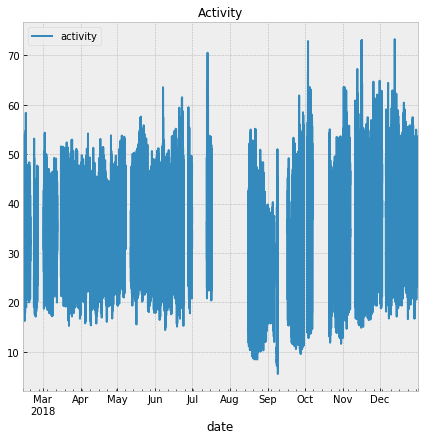

In [18]:
train_targets["activity"].plot()
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

Text(0.5, 1.0, 'Atactic fraction')

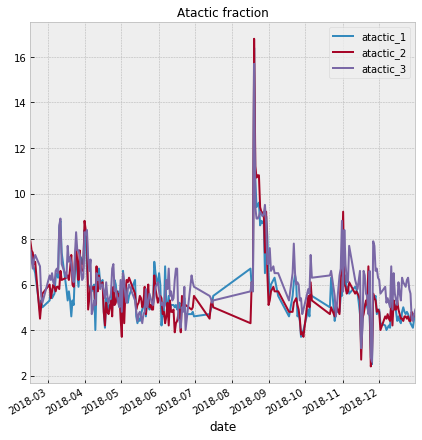

In [19]:
ACOLS = ["atactic_1", "atactic_2", "atactic_3"]

train_targets.loc[train_targets[ACOLS].notnull().all(axis=1), ACOLS].plot()
plt.legend(loc=0)
plt.tight_layout()
plt.title("Atactic fraction", fontsize=12)

# Признаки

In [0]:
PERIODS = ["1H", "3H", "6H"]
AGGREGATES = ["mean", "median", "std", "max", "min"]

In [21]:
all_features = []

for period in tqdm.tqdm_notebook(PERIODS):
    for agg in AGGREGATES:
        rolling_features = data.rolling(period).aggregate(agg)
        rolling_features.rename(lambda x: "_".join([x, period, agg]), axis=1, inplace=True)
        all_features.append(rolling_features)
all_features = pd.concat(all_features, axis=1)

In [0]:
full_data = data.join(all_features)

In [0]:
activity_data = train_targets[["activity"]].join(full_data.shift(6, freq="H"))
activity_data = activity_data[activity_data.notnull().all(axis=1)]

In [24]:
activity_data.head()

,activity,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f15_6H_min,f16_6H_min,f17_6H_min,f18_6H_min,f19_6H_min,f20_6H_min,f21_6H_min,f22_6H_min,f23_6H_min,f24_6H_min,f25_6H_min,f26_6H_min,f27_6H_min,f29_6H_min,f30_6H_min,f31_6H_min,f32_6H_min,f33_6H_min,f34_6H_min,f35_6H_min,f36_6H_min,f37_6H_min,f38_6H_min,f39_6H_min,f40_6H_min,f41_6H_min,f42_6H_min,f43_6H_min,f44_6H_min,f45_6H_min,f46_6H_min,f47_6H_min,f48_6H_min,f49_6H_min,f50_6H_min,f51_6H_min,f52_6H_min,f53_6H_min,f54_6H_min,f55_6H_min
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-02-13 14:31:00,26.492102,49.007980,294.932866,1.675090,0.000051,0.024659,0.001633,1.724523e+06,729611.819621,1.179814,0.513436,1.681415,0.00005,0.024994,0.001625,761764.591826,1.187331,0.558663,343.152747,343.151724,343.113585,1.573941,1.612820,0.009769,0.009681,301.90616,0.484099,0.557320,0.233740,195.485726,145.428082,123.800293,66.707826,71.945526,68.780815,64179.140,151867.461239,144171.923340,343.25750,343.33810,...,1.187274,0.558392,343.152747,343.145621,343.111044,1.573941,1.61282,0.009761,0.00968,301.90616,0.484099,0.55732,0.233514,195.485726,145.390155,123.790156,66.654695,71.945526,68.728236,64130.855,151867.461239,144110.179996,343.25750,343.3381,343.29892,343.34326,255.799444,101038.0777,76.988889,343.1356,335.66540,335.73734,336.9162,336.97977,342.95605,332.80826,332.78198,5247.641087,4829.339027,520.791888
2018-02-13 14:32:00,34.102710,48.994400,294.932703,1.675766,0.000051,0.024727,0.001639,1.724582e+06,730361.831348,1.179867,0.513290,1.681492,0.00005,0.024928,0.001629,759461.107963,1.187246,0.558563,343.154272,343.159865,343.116637,1.573461,1.614684,0.009792,0.009695,301.92993,0.483961,0.557615,0.233675,195.580825,145.386293,124.295153,66.758421,71.957288,68.759196,64251.504,152158.972552,144231.221704,343.25485,343.34143,...,1.187246,0.558392,343.152747,343.145621,343.111044,1.573461,1.61282,0.009761,0.00968,301.90616,0.483961,0.55732,0.233514,195.485726,145.386293,123.790156,66.654695,71.945526,68.728236,64130.855,151867.461239,144110.179996,343.25485,343.3381,343.29892,343.34220,255.798889,101038.0777,76.977778,343.1325,335.63095,335.70050,336.9162,336.97977,342.95605,332.80826,332.78198,5000.878811,4829.339027,520.242810
2018-02-13 14:33:00,41.518222,48.970760,294.936968,1.675868,0.000051,0.024723,0.001641,1.724677e+06,730486.077321,1.186719,0.511677,1.681643,0.00005,0.024922,0.001629,760412.241982,1.187280,0.558469,343.150198,343.168005,343.117651,1.573785,1.613456,0.009796,0.009700,301.90567,0.483804,0.557747,0.234117,195.336998,145.523593,124.203746,66.790413,72.011254,68.779693,64292.312,152426.298143,144232.437181,343.26205,343.34540,...,1.187246,0.558392,343.150198,343.145621,343.111044,1.573461,1.61282,0.009761,0.00968,301.90567,0.483804,0.55732,0.233514,195.336998,145.386293,123.790156,66.654695,71.945526,68.728236,64130.855,151867.461239,144110.179996,343.25485,343.3381,343.29892,343.34220,255.798333,101038.0777,76.966667,343.1325,335.57654,335.65533,336.9162,336.97977,342.95605,332.80826,332.78198,4751.941204,4829.339027,520.242810
2018-02-13 14:34:00,38.896862,48.952991,294.935404,1.675002,0.000051,0.024708,0.001646,1.724621e+06,730061.574144,1.186838,0.511305,1.681514,0.00005,0.025069,0.001633,758510.955941,1.187319,0.558569,343.153258,343.163931,343.122229,1.574133,1.615544,0.009814,0.009702,301.92905,0.483762,0.557368,0.234114,195.578388,145.655553,123.860564,66.786427,71.998048,68.740583,64244.836,152378.899642,144174.016885,343.26550,343.34335,...,1.187246,0.558392,343.150198,343.145621,343.111044,1.573461,1.61282,0.009761,0.00968,301.90567,0.483762,0.55732,0.233514,195.336998,145.386293,123.790156,66.654695,71.945526,68.728236,64130.855,151867.461239,144110.179996,343.25485,343.3381,343.29892,343.34220,255.797778,101038.0777,76.955556,343.1325,335.53976,335.63748,336.9162,336.97977,342.95605,332.80826,332.78198,4

In [0]:
tr_data = activity_data[:"2018-10-13"]
cv_data = activity_data["2018-10-14":]

## Тривиальные бенчмарки

In [26]:
print(f"MAPE (last known value, cross-validation set): {100 * mape(cv_data['activity'], tr_data['activity'].iloc[-1]):.2f}%")
print(f"MAPE (median, cross-validation set): {100 * mape(cv_data['activity'], tr_data['activity'].median()):.2f}%")

MAPE (last known value, cross-validation set): 10.99%
MAPE (median, cross-validation set): 13.54%


In [0]:
naive_baseline = activity_test_target.copy()
naive_baseline["rubber"] = tr_data['activity'].iloc[-1]
naive_baseline.to_csv(DATA_DIR.joinpath("activity_naive_baseline.csv"))

## Модель

In [0]:
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score

In [0]:
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)

In [0]:
tf.keras.backend.clear_session()

data_in = keras.Input(shape=(tr_data.shape[1]-1,), name="img_in")

dense_1 = layers.Dense(32, activation="relu")(data_in)
data_out = layers.Dense(1, activation="linear")(dense_1)
model = keras.Model(data_in, data_out)
model.compile(optimizer='adam', loss='mse')

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          [(None, 880)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                28192     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________


In [0]:
EPOCHS = 500
BS = 1024

In [0]:
center, scale = tr_data.iloc[:, 1:].mean().values, tr_data.iloc[:, 1:].std().values
trn = (tr_data.iloc[:, 1:].values - center)/scale
cvn = (cv_data.iloc[:, 1:].values - center)/scale

In [34]:
model.fit(trn, (tr_data[["activity"]].values - tr_data["activity"].mean())/tr_data["activity"].std(),
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=False,
          validation_data=(cvn, (cv_data[["activity"]].values - tr_data["activity"].mean())/tr_data["activity"].std()),
          callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Train on 216400 samples, validate on 84337 samples
Epoch 1/500
216400/216400 [==============================] - 3s 14us/sample - loss: 2.6044 - val_loss: 2.1192
Epoch 2/500
216400/216400 [==============================] - 2s 7us/sample - loss: 2.6247 - val_loss: 8.0473
Epoch 3/500
216400/216400 [==============================] - 2s 7us/sample - loss: 2.1013 - val_loss: 1.8668
Epoch 4/500
216400/216400 [==============================] - 2s 7us/sample - loss: 1.3876 - val_loss: 7.9356
Epoch 5/500
216400/216400 [==============================] - 2s 7us/sample - loss: 1.0819 - val_loss: 0.9748
Epoch 6/500
216400/216400 [==============================] - 2s 7us/sample - loss: 0.9372 - val_loss: 1.2169
Epoch 7/500
216400/216400 [==============================] - 2s 7us/sample - loss: 0.9619 - val_loss: 1.7357
Epoch 8/500
216400/216400 [==============================] - 2s 9us/sample - loss: 0.7766 - val_loss: 0.8575
Epoch 9/500
216400/216400 [==============================] - 2s 8us/sample -

In [0]:
tr_preds = model.predict(trn) * tr_data["activity"].std() + tr_data["activity"].mean()
cv_preds = model.predict(cvn) * tr_data["activity"].std() + tr_data["activity"].mean()

tr_preds = pd.Series(tr_preds.flatten(), index=tr_data.index, name="activity_pred").sort_index()
cv_preds = pd.Series(cv_preds.flatten(), index=cv_data.index, name="activity_pred")

Text(0.5, 1.0, 'Activity')

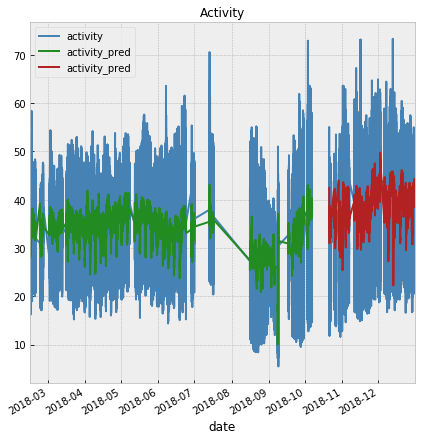

In [36]:
tr_data["activity"].plot(c="steelblue")
cv_data["activity"].plot(c="steelblue", label="")
tr_preds.plot(c="forestgreen")
cv_preds.plot(c="firebrick")
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

Text(0, 0.5, 'predicted activity')

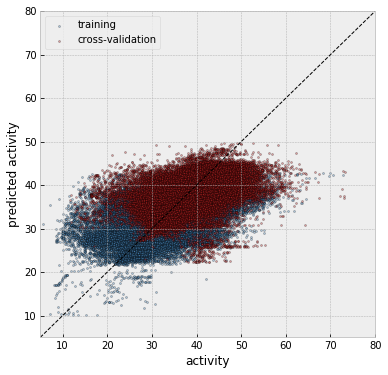

In [37]:
plt.scatter(tr_data["activity"], tr_preds, s=4, alpha=0.4, edgecolor="k", c="steelblue", label="training")
plt.scatter(cv_data["activity"], cv_preds, s=4, alpha=0.4, edgecolor="k", c="firebrick", label="cross-validation")

plt.xlim(5, 80)
plt.ylim(5, 80)
plt.legend(loc=0)
plt.plot([5, 80], [5, 80], "--", c="k", linewidth=1)
plt.xlabel("activity")
plt.ylabel("predicted activity")

In [40]:
print(f"MAPE (training set): {100 * mape(tr_data['activity'].values, tr_preds.values):.2f}%")
print(f"MAPE (cross-validation set): {100 * mape(cv_data['activity'].values, cv_preds.values):.2f}%")

MAPE (training set): 9.51%
MAPE (cross-validation set): 9.51%


Наша модель недостаточно хорошо справляется со слишком большими и слишком маленькими значениями целевой переменной. Подумайте, как это исправить.

In [0]:
test_activity_data = activity_test_target.join(full_data.shift(6, freq="H")).ffill()
ts_preds = model.predict((test_activity_data.values - center)/scale) * tr_data["activity"].std() + tr_data["activity"].mean()

ts_preds = pd.DataFrame(ts_preds, columns=["activity"], index=activity_test_target.index)
ts_preds.loc[activity_test_target.index].to_csv(DATA_DIR.joinpath("activity_nn_baseline.csv"))

# Атактика

В случае атактики у нас есть намного меньше данных. Будем предполагать, что сеть для прогноза активности катализатора строит представление, которые релевантные и для прогноза атактики.

In [0]:
encoder_model = keras.Model(inputs=model.input,
                            outputs=model.get_layer("dense").output)

In [0]:
tr_enc = encoder_model.predict(trn)
cv_enc = encoder_model.predict(cvn)

In [53]:
tr_enc.shape

(216400, 32)

In [0]:
tr_df = pd.DataFrame(tr_enc, columns=[f"enc{i}" for i in range(tr_enc.shape[1])], index=tr_data.index)
cv_df = pd.DataFrame(cv_enc, columns=[f"enc{i}" for i in range(cv_enc.shape[1])], index=cv_data.index)

Признаки уже сдвинуты на 6 часов, поэтому их не нужно сдвигать снова:

In [0]:
atactic_data = train_targets[ACOLS].join(pd.concat([tr_df, cv_df]))

In [0]:
atactic_data = atactic_data[atactic_data.notnull().all(axis=1)]

In [72]:
atactic_data

,atactic_1,atactic_2,atactic_3,enc0,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,enc9,enc10,enc11,enc12,enc13,enc14,enc15,enc16,enc17,enc18,enc19,enc20,enc21,enc22,enc23,enc24,enc25,enc26,enc27,enc28,enc29,enc30,enc31
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-02-15 08:00:00,7.3,7.5,7.1,0.000000,3.762919,0.000000,0.000000,0.000000,0.000000,0.000000,1.008554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.572423,0.000000,0.000000,0.000000,0.000000,4.879458,0.000000,0.000000,0.000000,0.000000,5.462121,0.000000,0.317295,4.037532,3.094502,2.640368,2.008656,4.845889
2018-02-16 08:00:00,6.9,7.4,6.7,0.000000,1.694896,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170642,0.000000,0.000000,0.000000,1.024047,0.243060,2.024618,0.000000,0.000000,0.000000,0.728526,0.769783,0.000000,2.192941,0.000000,0.000000,0.295330,2.615486,2.526848,1.933943,1.480964,0.913023
2018-02-17 08:00:00,6.7,6.9,7.1,0.000000,2.151287,0.000000,0.000000,0.923294,0.943693,0.000000,0.310988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.448653,0.000000,1.777827,0.000000,0.259228,0.000000,0.187337,2.793473,0.000000,5.141182,0.000000,0.000000,0.000000,0.525611,1.182020,2.777057,2.963995,0.000000
2018-02-18 08:00:00,6.5,7.0,7.3,0.000000,2.984089,0.000000,0.062546,0.835868,0.911037,0.000000,1.461937,0.000000,0.000000,3.055310,0.000000,0.000000,0.000000,1.644744,0.000000,3.335647,0.000000,1.135641,0.000000,0.925129,1.371907,0.000000,6.764623,0.000000,0.000000,0.000000,0.123216,2.089312,1.986030,1.768008,0.000000
2018-02-22 08:00:00,4.8,4.5,6.8,5.993777,0.000000,0.000000,0.000000,0.000000,0.000000,1.799448,7.618384,0.000000,3.621880,0.000000,0.000000,0.000000,4.533153,0.000000,0.000000,0.000000,5.933065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.938247,0.000000,0.000000,0.000000,0.000000,0.000000,8.946190,0.000000
2018-02-23 08:00:00,5.3,5.1,5.5,0.000000,2.277532,0.078280,0.829635,0.000000,2.075776,0.000000,3.421925,0.000000,0.000000,0.805645,0.000000,0.000000,0.000000,0.586459,0.000000,0.000000,0.735626,0.000000,0.000000,0.000000,0.153761,0.779636,8.437447,2.269137,0.000000,0.000000,0.857554,0.239845,0.000000,1.119437,0.000000
2018-02-24 08:00:00,5.0,5.6,5.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.958486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.279298,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.685589,0.000000
2018-03-02 08:00:00,5.3,6.0,6.4,0.000000,0.301824,0.647591,1.813010,0.000000,0.000000,0.000000,1.251903,2.476014,0.000000,4.311228,0.000000,0.000000,0.342016,1.504504,0.033965,3.109875,1.846978,0.000000,1.109705,2.744230,0.000000,1.884122,4.727977,1.042589,1.849189,0.000000,0.000000,0.790067,0.000000,0.928956,0.000000
2018-03-03 08:00:00,5.8,5.4,6.2,0.087231,0.000000,1.063807,2.192331,0.000000,1.452005,0.000000,2.851527,1.950978,0.000000,0.000000,0.000000,0.201342,0.025120,0.000000,0.000000,1.341259,0.000000,0.041479,1.733248,1.087798,1.604706,1.112007,5.470472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062968,0.000000


In [0]:
at_tr_data = atactic_data[:"2018-11-15"]
at_cv_data = atactic_data["2018-11-16":]

## Тривиальные бенчмарки

In [75]:
mapes = []

for cl in ACOLS:
    local_mape = mape(at_cv_data[cl], at_tr_data[cl].iloc[-1])
    mapes.append(local_mape)
    
print(f"MAPE (last known value, cross-validation set): {100 * np.mean(mapes):.2f}%")

mapes = []

for cl in ACOLS:
    local_mape = mape(at_cv_data[cl], at_tr_data[cl].median())
    mapes.append(local_mape)

print(f"MAPE (median, cross-validation set): {100 * np.mean(mapes):.2f}%")

MAPE (last known value, cross-validation set): 18.68%
MAPE (median, cross-validation set): 22.77%


In [0]:
naive_baseline = atactic_test_target.copy()

for cl in ACOLS:
    naive_baseline[cl] = at_tr_data[cl].iloc[-1]
naive_baseline.to_csv(DATA_DIR.joinpath("atactic_naive_baseline.csv"))

## Модели

In [0]:
from sklearn.linear_model import LinearRegression, ARDRegression
from sklearn.ensemble import RandomForestRegressor

In [0]:
tsn = (test_activity_data.values - center)/scale
ts_enc = encoder_model.predict(tsn)
ts_df = pd.DataFrame(ts_enc, columns=[f"enc{i}" for i in range(ts_enc.shape[1])], index=test_activity_data.index)

ts_atactic_data = atactic_test_target.join(ts_df)

Target atactic_1:
	MAPE atactic_1 (training set): 12.86%
	MAPE atactic_1 (cross-validation set): 17.12%


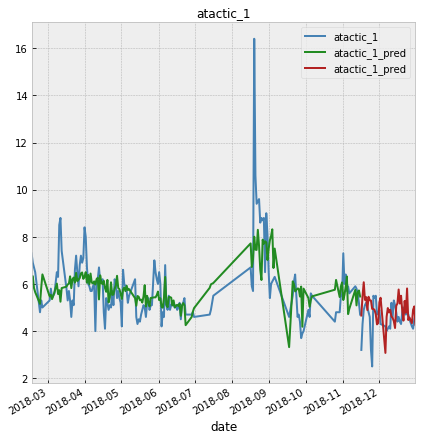

Target atactic_2:
	MAPE atactic_2 (training set): 13.95%
	MAPE atactic_2 (cross-validation set): 16.90%


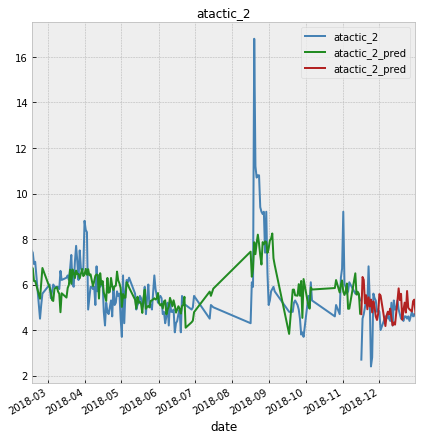

Target atactic_3:
	MAPE atactic_3 (training set): 12.26%
	MAPE atactic_3 (cross-validation set): 20.66%


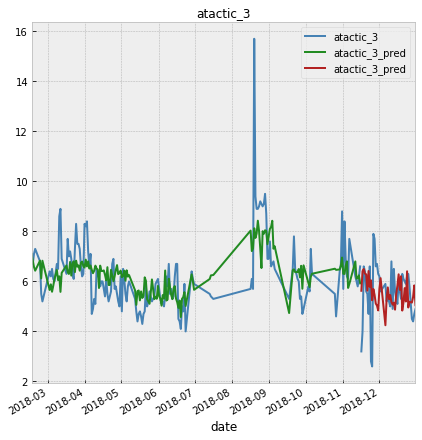

MAPE (training set): 13.02%
MAPE (cross-validation set): 18.23%


In [107]:
tr_mapes = []
cv_mapes = []
ts_preds = atactic_test_target.copy()

for cl in ACOLS:
    model =  ARDRegression()

    model.fit(at_tr_data.iloc[:, 3:], at_tr_data[cl])

    tr_preds = model.predict(at_tr_data.iloc[:, 3:])
    cv_preds = model.predict(at_cv_data.iloc[:, 3:])

    print(f"Target {cl}:")
    print(f"\tMAPE {cl} (training set): {100 * mape(at_tr_data[cl], tr_preds):.2f}%")
    print(f"\tMAPE {cl} (cross-validation set): {100 * mape(at_cv_data[cl], cv_preds):.2f}%")

    tr_mapes.append(mape(at_tr_data[cl], tr_preds))
    cv_mapes.append(mape(at_cv_data[cl], cv_preds))

    tr_preds = pd.Series(tr_preds, index=at_tr_data.index, name=f"{cl}_pred")
    cv_preds = pd.Series(cv_preds, index=at_cv_data.index, name=f"{cl}_pred")

    at_tr_data[cl].plot(c="steelblue")
    at_cv_data[cl].plot(c="steelblue", label="")
    tr_preds.plot(c="forestgreen")
    cv_preds.plot(c="firebrick")
    plt.legend(loc=0)
    plt.tight_layout()
    plt.title(cl, fontsize=12)
    plt.show()

    ts_preds[cl] = model.predict(ts_atactic_data)

print(f"MAPE (training set): {100 * np.mean(tr_mapes):.2f}%")
print(f"MAPE (cross-validation set): {100 * np.mean(cv_mapes):.2f}%")

In [0]:
ts_preds.to_csv(DATA_DIR.joinpath("atactic_nn_baseline.csv"))